<a href="https://colab.research.google.com/github/r-doz/PML2025/blob/main/./09_VI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 9: Variational Inference

This notebook is based on the previous work of Ginevra Carbone. 

## The problem

The problem is the same that we face in EM algorithm: **performing inference in presence of latent variables**.

Namely, we studied how we can perform parameter (i.e. $\theta$) estimation when in scenarios in which the joint distribution is expressed in the following form: $P(X, Z | \theta)$. We saw how it is often intractable to marginalize this joint distribution w.r.t. $Z$ in order to retain $P(X | \theta)$ and how we can exploit the alternate optimization of the EM algorithm to solve this problem.

**IMPORTANT:** 

We already saw in EM algorithm that the joint distribution $P(X, Z | \theta)$ can be factorized into:
$$
P(X, Z | \theta) = P(X | \theta) \cdot P(Z | X, \theta) 
$$
and that, since we don't know anything about $P(Z | X, \theta)$, we assume this quantity to be approximated by $q(Z)$. This is the so-called **variational approximation**, allowing us to express the joint distirbution as:
$$
P(X, Z | \theta) \approx P(X | \theta) \cdot q(Z)
$$

### But what's new?

Why are we disentangling the latent variables $Z$ from the parameters $\theta$?
If we "couple" the latent variables (from now on: *local latent variables*) with the parameters (from now on: *global latent variables*) we can perform inference on the parameters also, and this is really interesting. 

Let's represent $Z$ as $Z = (z_1, ..., z_n, \theta)$; we can rephrase the problem that we saw in the previous lab as:
$$
P(X, Z) = P(X) \cdot P(Z | X) \Biggl( \approx P(X) \cdot q(Z) \Biggr)
$$

*From a slightly different perspective:*
$$
P(X, Z) = P(X | Z) \cdot P(Z) = P(Z | X) \cdot P(X) \Rightarrow P(Z | X) = \frac{P(X | Z) \cdot P(Z)}{P(X)}
$$
Here, $P(Z \mid X)$ is the **posterior distribution over the latent variables** $Z$, given the observed data $X$.

While the numerator $P(X \mid Z) \cdot P(Z)$ is often relatively easy to evaluate for a given $Z$, the marginal likelihood (also known as the evidence) $P(X)$ is typically intractable, since it requires integrating over all possible latent variables:

$$
P(X) = \int P(X \mid Z) \cdot P(Z) \, dZ
$$

This intractability makes exact inference difficult, which motivates the use of approximate inference techniques such as variational inference.

A way we can solve this problem, is to find a distribution $q(Z)$ that is "similar" to the target distribution $P(Z | X)$, but from which it is easy to sample (for example a gaussian).

### Variational Inference

In order to obtain the *most similar* $q(Z)$ with respect to $P(Z | X)$, we want their distance to be *as small as possible*, thus we ask their Kullback-Liebler divergence to be null:
$$
KL[\, q(Z) \, || \, p(Z | X) \, ] = - \int q(Z) \cdot \Bigl[ log \, p(Z | X) - log \, q(Z) \Bigr] dZ = 0
$$

Due to the following relation: 
$$
log \, p(X) = \mathcal{L}(q(Z)) + KL[\, q(Z) \, || \, p(Z | X) \, ] 
$$

we know that asking for $KL[\, q(Z) \, || \, p(Z | X) \, ] = 0$ retains the same $q(Z)$ as the one obtained by maximizing the ELBO $\mathcal{L}(q(Z))$.

The problem of finding $\argmax_{q(Z)} \, \mathcal{L}(q(Z))$ can be simplified in a **parameter optimization process** if we assume that $q(Z)$ belongs to a **parametric family of distributions**, in mathematical terms:
$$
q(Z)  \in  \mathcal{Q} = \{q(Z | \lambda), \, \lambda \in \mathcal{R}^k\}
$$

So in variational inference we reduce the inference problem to an optimization problem:
$$ \argmax_{q(Z|\lambda)} \, \mathcal{L}(q(Z | \lambda)) $$

Considering that we are using a parametric family of distributions $q(Z |\lambda)$, then this reduces to the optimization of a set of parameters:
$$\argmax_{\lambda} \, \mathcal{L} (\lambda)$$

### Black Box Variational Inference

In order to find $\argmax_{\lambda} \text{ELBO}(\lambda)$, we would like to perform a gradient-based optimization, but $\nabla_\lambda\text{ELBO}(\lambda)$ contains an intractable expectation.

We would like to estimate the gradient of this expectation by Monte Carlo with respect to variational parameters and then perform gradient ascent on this estimate.

Depending on $q_\lambda$, there are two ways to do this:
1. reparametrization trick;
2. if not reparametrizable, rewrite the gradient of the expectation as an expectation of the gradient (more complicated).

#### SOLUTION #1: Reparametrization Trick

The reparametrization trick consist in writing samples $Z$ from $q(Z |\lambda)$ as $Z = f_{\nu}(\boldsymbol{\varepsilon})$ where $\varepsilon$ is a random variable sampled from a distribution $\hat{q}(\varepsilon)$ that does not depend on $\lambda$.
*For example*: sampling $Z \sim \mathcal{N}(\mu, \sigma)$ is equivalent to $Z = \mu + \sigma \cdot \varepsilon$ with $\varepsilon \sim \mathcal{N}(0, 1)$, $\nu = (\mu, \sigma)$.

The overall set of parameters to be optimized will be $\hat{\lambda} = (\lambda, \nu)$, where $\nu$ are the parameters of the function $f$.

Consequently, starting from:
$$
\mathcal{L}(\lambda) = \mathbb{E}_{\, Z \sim q(Z | \lambda)} \, \Bigl[ log \, P(X, Z) - log \, q(Z | \lambda) \Bigr]
$$
we can use this reparametrization and obtain: 
$$
\mathcal{L}(\hat{\lambda}) = \mathbb{E}_{\, \varepsilon \sim \hat{q}(\varepsilon)} \, \Bigl[ log \, P(X, f_{\nu}(\varepsilon)) - log \, q(f_{\nu}(\varepsilon) | \lambda) \Bigr]
$$

Note that this expectation does not depend anymore on $\lambda$!


Let's consider now its gradient: 
$$
\nabla_{\hat{\lambda}} \, \mathcal{L}(\hat{\lambda}) = \mathbb{E}_{\, \varepsilon \sim \hat{q}(\varepsilon)} \, \Bigl[ \nabla_{\hat{\lambda}} \, log \, P(X, f_{\nu}(\varepsilon)) - \nabla_{\hat{\lambda}} \, log \, q(f_{\nu}(\varepsilon) | \lambda) \Bigr]
$$

**Technical note:** the relevant thing about the fact that the expectation inside $\mathcal{L}(\hat{\lambda})$ does not depend anymore on $\lambda$ is that we can *we can bring the gradient operator inside the expectation*.

The Monte Carlo estimate of this gradient will be given by:

$$
\nabla_{\hat{\lambda}} \, \mathcal{L}(\hat{\lambda}) \approx \frac{1}{S} \sum_{s=1}^S  \nabla_{\hat{\lambda}} \Bigl[ \, log \, P(X, f_{\nu}(\varepsilon_s)) - \, log \, q(f_{\nu}(\varepsilon_s) | \lambda) \Bigr] \; \text{where} \; \varepsilon_s \sim \hat{q}(\varepsilon)
$$

**Example:**
Find a variational approximation of $p(z) \propto e^{-3|x-2|}$ using a gaussian guide $q_{\mu, \sigma}(z) = \mathcal{N}(z|\mu,\sigma)$

  0%|          | 0/1000 [00:00<?, ?it/s]

loss=0.468
mean = 2.070, std = 0.437


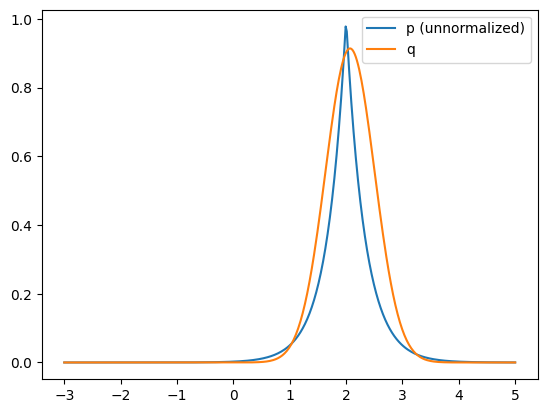

In [1]:
import torch
from torch import distributions
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np

def gradient_descent_optimization(*, loss_function, lr: float, n_iter: int, initial_guess: np.ndarray) -> np.ndarray:
    w = torch.tensor(initial_guess, dtype=torch.float32, requires_grad=True)
    for _ in tqdm(range(n_iter)):
        loss = loss_function(w)
        loss.backward()
        with torch.no_grad():
            w -= lr * w.grad
        w.grad = None
    print(f"loss={ loss.item():.4g}")
    return w.cpu().detach().numpy()

def log_p(z) -> torch.Tensor:
    return -3 * torch.abs(z-2)

def log_q(z, mu, sigma) -> torch.Tensor:
    return distributions.Normal(mu, sigma).log_prob(z)

def loss(param):
    eps = torch.randn(10)
    z = param[0] + param[1] * eps
    elbo_sample = log_p(z) - log_q(z, param[0], param[1])
    return -elbo_sample.mean(0)
    

params = gradient_descent_optimization(loss_function=loss,
                                        lr=0.01,
                                        n_iter=1000,
                                        initial_guess=[0.0, 10.0])

mu = params[0]
sigma = params[1]

print(f"mean = {mu:.3f}, std = {sigma:.3f}")

# plotting the result
z_values = torch.linspace(-3, 5, 400)
log_p_values = log_p(z_values).exp()
log_q_values = log_q(z_values, mu, sigma).exp()
plt.figure(dpi=100)
plt.plot(z_values.numpy(), log_p_values.numpy(), label='p (unnormalized)')
plt.plot(z_values.numpy(), log_q_values.numpy(), label='q')
_ = plt.legend()

#### SOLUTION #2: Non-reparametrizable guide

In many cases the guide is **not reparametrizable**, but also in this case it is *still possible to approximate the gradient*, at the price of a higher variance of the estimation (see lectures' notes for a proof):

$$\nabla_\lambda\text{ELBO}(\lambda)  \approx \frac{1}{S} \sum_{s=1}^S  \nabla_\lambda \left[ \log q_{\lambda}(\boldsymbol{z}_s) \right] \left( \log{\tilde{p}(\boldsymbol{z}_s)} - \log{q_{\lambda}(\boldsymbol{z}_s)} \right)$$

This is how `Pyro` computes the gradient for any guide (see next part). 

## Variational Inference with Pyro

**Stochastic (or Black-Box) Variational Inference** is implemented as a `Pyro` class

```
SVI(model, guide, optim, loss)
```

whose arguments are:
- a `model()` function, implementing the generative process, conditioned on the observations;
- a `guide()` function, representing the variational distribution $q(Z | \lambda)$ (*it needs to provide a valid joint probability density function over all the latent random variables in the model*);
- `optim`, a PyTorch optimizer;
- `loss`, i.e. the ELBO loss function.


Keep in mind that `model()` and `guide()` must:
- always take the *same arguments* as inputs;
- both **sample the parameters that have to be inferred** and use the *same names* for them, but not necessarily the same distributions.

For example:

```
def model(data):
    pyro.sample("theta", Uniform(-1.,1.))
    ...
   
def guide(data):
    pyro.sample("theta", Normal(0.,1.))
    ... 
```

The **optimization step** is performed by calling the `step()` function on the training batch data:

```
optim = Adam({lr:0.02}) 
loss = ELBO_loss()
svi = SVI(model, guide, optim, loss)

for step in range(n_steps):
    for batch_data in training_data:
        svi.step(batch_data)
```

The name "stochastic" is due to the batch training technique.

### Example: Linear Regression with SVI

First, we load the data and normalize it:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('https://raw.githubusercontent.com/r-doz/PML2025/main/data/vi_regression.csv')


In [3]:
# Let's normalize the data, in order to improve the convergence of optimizers
df = (df - df.mean()) / df.std()
df

,x,y
0,0.599648,-0.395757
1,0.243209,0.186381
2,-0.074169,1.126055
3,-0.257967,1.055119
4,0.459826,-1.072461
5,2.121977,-1.437409
6,1.287216,-1.230960
7,-0.238139,0.244570
8,-2.153843,0.725214
9,-0.265387,1.743719


The data has just one feature and one value to predict. The following is a linear model describing the observed data:

\begin{align*}



& p(y_i | x_i, w, b, \sigma) = \mathcal{N}(y_i | x_i \cdot w + b, \sigma) \\

& w \sim \mathcal{N}(0,100) \\
& b \sim \mathcal{N}(0,100) \\
& \sigma \sim \text{Uniform}(0,100) \\

\end{align*}



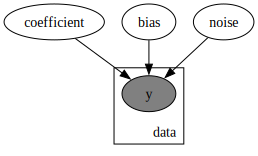

In [31]:
import pyro
import torch
from pyro.distributions import Normal, Uniform, LogNormal
from pyro.distributions import constraints

W_PRIOR_SIGMA = 100.0
BIAS_PRIOR_SIGMA = 100.0
SIGMA_MAX = 100.0

# P(X, Z)
def model(x: torch.Tensor, y: torch.Tensor | None = None) -> torch.Tensor:
    # priors
    coefficient = pyro.sample('coefficient', Normal(0, W_PRIOR_SIGMA))
    bias = pyro.sample('bias', Normal(0, BIAS_PRIOR_SIGMA))
    sigma = pyro.sample('noise', Uniform(0, SIGMA_MAX))
    
    # likelihood/observation
    with pyro.plate('data', len(x)):
        y = pyro.sample('y', Normal(coefficient * x + bias, sigma), obs=y)
    return y

pyro.render_model(model, model_args=(torch.zeros(1),torch.zeros(1)))

If we want to do VI, we have to build a guide.

A guide is made in the same way we build models. Being a distribution over the latent variables, you have to sample those inside its definition, using the same names as in the model, and you can define parameters that parametrize the distribution.

Moreover, the arguments of the guide function has to be the same of the model.

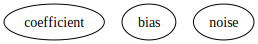

In [ ]:
# q(Z)
def guide(x: torch.Tensor, y: torch.Tensor | None = None):
    
    # guide optimizable parameters
    coefficient_mu = pyro.param('coefficient_mu', torch.tensor(0.0))
    coefficient_sigma = pyro.param('coefficient_sigma', torch.tensor(10.0), constraint=constraints.positive)
    
    bias_mu = pyro.param('bias_mu', torch.tensor(0.0))
    bias_sigma = pyro.param('bias_sigma', torch.tensor(10.0), constraint=constraints.positive)
    
    sigma_mu = pyro.param('sigma_mu', torch.tensor(0.0))
    sigma_sigma = pyro.param('sigma_sigma', torch.tensor(1.0), constraint=constraints.positive)

    # guide distributions 
    coefficient = pyro.sample('coefficient', Normal(coefficient_mu, coefficient_sigma))
    bias = pyro.sample('bias', Normal(bias_mu, bias_sigma))
    sigma = pyro.sample('noise', LogNormal(sigma_mu, sigma_sigma))
    
    return coefficient, bias, sigma

# This doesn't make much sense, but it's just to show the guide
pyro.render_model(guide, model_args=(torch.zeros(1),torch.zeros(1)))

Notice that we defined a guide where each latent variable is an independent distribution, so we are using a **mean-field approximation**.

Now we can perform SVI and optimize the guide's parameters:

  0%|          | 0/200 [00:00<?, ?it/s]

Elbo loss: 38.528857707977295


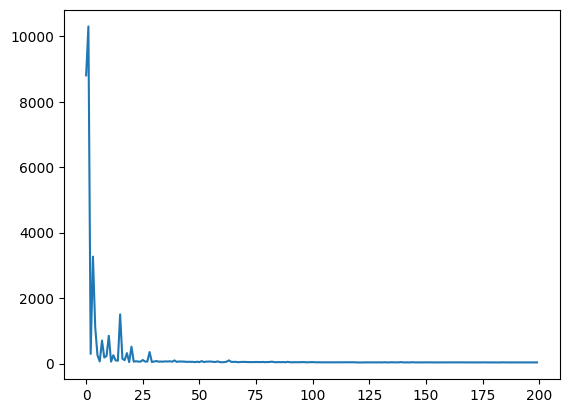

In [6]:
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import ClippedAdam
from tqdm.notebook import tqdm

pyro.clear_param_store()

# convert the data to torch tensors
data = torch.tensor(df.to_numpy(), dtype=torch.float32)
x = data[:,0] 
y = data[:,1]

NUM_PARTICLES = 1 # number of samples to estimate the gradient od the ELBO
STEPS = 200 # optimization steps

# defining the SVI object
svi = SVI(model=model,
          guide=guide,
          optim=ClippedAdam({'lr': 0.05}),
          loss=Trace_ELBO(num_particles=NUM_PARTICLES))

# fitting the guide to the data
loss = np.zeros(STEPS)
for i in tqdm(range(STEPS)):
    # executes the optimization step: computes the loss        
    loss[i] = svi.step(x, y)
    
print(f"Elbo loss: {loss[-1]}")
_ = plt.plot(loss)

Where are the optimized parameters of the guide? They are saved under the hood in an object named `pyro.get_param_store()`:

In [7]:
dict(pyro.get_param_store())

{'coefficient_mu': tensor(-0.7241, requires_grad=True),
 'coefficient_sigma': tensor(0.1983, grad_fn=<AddBackward0>),
 'bias_mu': tensor(-0.0758, requires_grad=True),
 'bias_sigma': tensor(0.1734, grad_fn=<AddBackward0>),
 'sigma_mu': tensor(-0.2742, requires_grad=True),
 'sigma_sigma': tensor(0.1793, grad_fn=<AddBackward0>)}

Now we can use the fitted guide to sample from the predictive distribution, `pyro` has a function to do that:

In [12]:
from pyro.infer import Predictive

predictive = Predictive(model=model, guide=guide, num_samples=1_000)

# Let's use as input some equidistant points in the range of the data
x_linspace = torch.linspace(-4, 4, 20)

mf_pred = predictive(x_linspace)
mf_pred.keys()

dict_keys(['coefficient', 'bias', 'noise', 'y'])

So we can obtain both samples from the posterior (of the latent variables) and samples from the predictive

In [26]:
# mf_pred
coefficient_pred = mf_pred['coefficient'].detach().numpy()

coefficient_mean = coefficient_pred.mean(axis=0)
coefficient_std = coefficient_pred.std(axis=0)  
coefficient_mean
coefficient_std

array([0.19947685], dtype=float32)

Let's use the simulations to plot theregression line and the confidence interval:

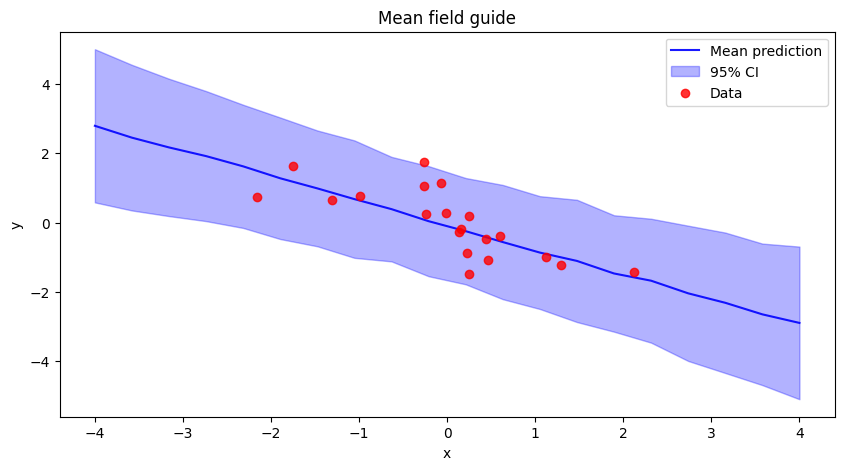

In [23]:
y_pred = mf_pred['y'].detach().numpy()

y_mean = y_pred.mean(axis=0)
y_std = y_pred.std(0)

# Compute confidence interval bounds
ci_upper = y_mean + 1.96 * y_std
ci_lower = y_mean - 1.96 * y_std

# Plot mean and confidence interval
plt.figure(figsize=(10, 5))
plt.plot(x_linspace, y_mean, color='blue', label='Mean prediction', alpha = 0.9)
plt.fill_between(x_linspace, ci_lower, ci_upper, color='blue', alpha=0.3, label='95% CI')
plt.scatter(df['x'], df['y'], color='red', label='Data', alpha = 0.8, zorder=2)
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Mean field guide')
plt.show()

#### Auto Guides

There is also the possibility to avoid specifying the guide manually, and just use a "standard" guide, for example a diagonal normal or a multivariate normal. Pyro is able to recognize the latent variables of a model and build one of these standard guides.

In this case let's increase the complexity of the guide using a multivariate normal (so allowing correlations among latent variables): 

  0%|          | 0/400 [00:00<?, ?it/s]

Elbo loss: 92.96475052833557


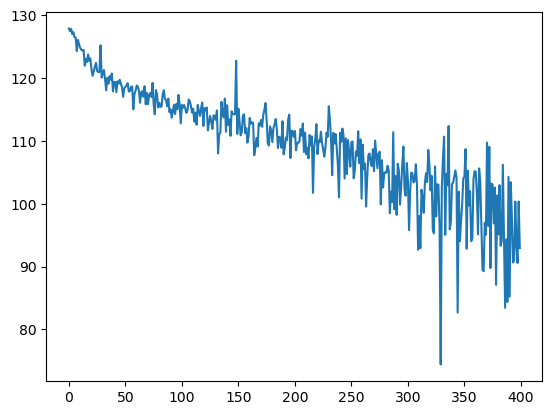

In [12]:
from pyro.infer.autoguide import AutoMultivariateNormal

pyro.clear_param_store()

# Building the guide automatically 
auto_guide = AutoMultivariateNormal(model)

NUM_PARTICLES = 2
STEPS = 400
AutoMultivariateNormal
svi = SVI(model=model,
          guide=auto_guide,
          optim=ClippedAdam({'lr': 0.1}),
          loss=Trace_ELBO(num_particles=NUM_PARTICLES))

loss = np.zeros(STEPS)
for i in tqdm(range(STEPS)):        
    loss[i] = svi.step(x, y)
print(f"Elbo loss: {loss[-1]}")
_ = plt.plot(loss)

In [13]:
dict(pyro.get_param_store())

{'AutoMultivariateNormal.loc': Parameter containing:
 tensor([-20.7355,   0.0554,  -1.4783], requires_grad=True),
 'AutoMultivariateNormal.scale': tensor([12.5449,  4.4069,  0.2790], grad_fn=<SoftplusBackward0>),
 'AutoMultivariateNormal.scale_tril': tensor([[ 1.0000,  0.0000,  0.0000],
         [-0.0465,  1.0000,  0.0000],
         [-2.5136,  0.2617,  1.0000]], grad_fn=<AddBackward0>)}

You can see that now you have also a covariance over the latent variables.

Unfortunately there are no names, so you have to follow the order you defined the latent variables.

Again, let's make a plot of the predictions:

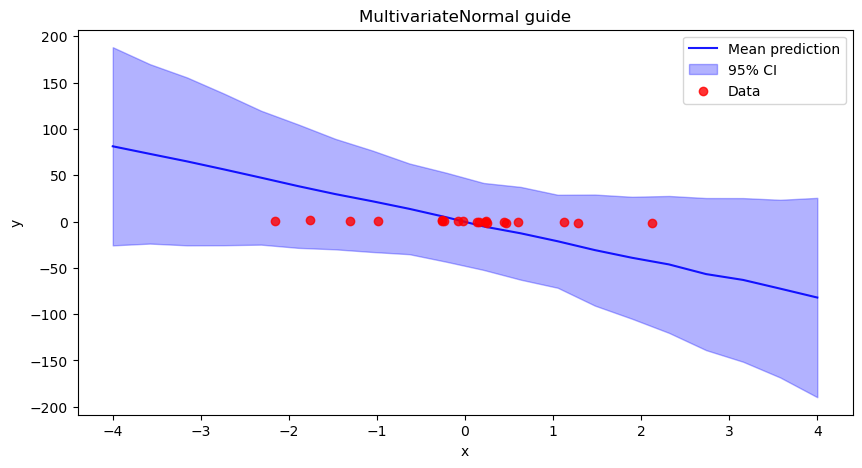

In [14]:
predictive = Predictive(model=model, guide=auto_guide, num_samples=1_000)

x_linspace = torch.linspace(-4, 4, 20)
pred = predictive(x_linspace)
y_pred = pred['y'].detach().numpy()

y_mean = y_pred.mean(axis=0)
y_std = y_pred.std(0)

# Compute confidence interval bounds
ci_upper = y_mean + 1.96 * y_std
ci_lower = y_mean - 1.96 * y_std

# Plot mean and confidence interval
plt.figure(figsize=(10, 5))
plt.plot(x_linspace, y_mean, color='blue', label='Mean prediction', alpha = 0.9)
plt.fill_between(x_linspace, ci_lower, ci_upper, color='blue', alpha=0.3, label='95% CI')
plt.scatter(df['x'], df['y'], color='red', label='Data', alpha = 0.8, zorder=2)
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('MultivariateNormal guide')
plt.show()